In [365]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import geopandas as gpd
from plotly.subplots import make_subplots
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from sklearn.calibration import CalibratedClassifierCV
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.datasets import BinaryLabelDataset
import tensorflow.compat.v1 as tf
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import BlackBoxAuditing
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
%matplotlib inline

1- Calculate metrics for data 
2- Model -> data




## Load Dataset

In [366]:
data = pd.read_csv('./Businesses.csv', engine='pyarrow')

df = pd.DataFrame(data)

df.head()

,borough_county,primary_sector,annual_turnover,number_of_employees,number_of_officers,entity_status,women_owned,2019_revenue,capex,cogs,cogs_plus_capex,costs,turnover_bands,accounts_receivable,capital_and_reserves,current_assets,current_liabilities,fixed_assets,long_term_liabilities,provisions_for_liabilities
0,Haringey,47 : Retail,0-632k,5-9 People,1,1,1,540536.0,158.79,5691.53,5850.32,531828.0317,0-632k,13328.0,13502.0,94341.0,71429.0,4094.0,13504.0,12857.0
1,Lambeth,41-43 : Construction,0-632k,0-4 People,2,1,0,231292.0,215.50,6471.54,6687.04,220525.8335,0-632k,9506.0,23927.0,52241.0,25061.0,4728.0,7981.0,4009.0
2,Cheshire East,05-39 : Production,0-632k,0-4 People,1,1,0,203270.0,100.89,3385.61,3486.50,197711.6193,0-632k,6123.0,47029.0,40721.0,31488.0,106244.0,68448.0,5038.0
3,Dudley,49-53 : Transport & Storage (inc. postal),0-632k,0-4 People,1,1,0,118794.0,253.34,3885.55,4138.89,110593.1715,0-632k,2929.0,21938.0,65519.0,46121.0,10131.0,7590.0,7840.0
4,Cheltenham,41-43 : Construction,0-632k,0-4 People,1,1,1,391341.0,129.17,4731.59,4860.76,383104.9832,0-632k,16083.0,38807.0,84212.0,40289.0,8186.0,13302.0,7252.0


## Checking for nulls

In [367]:
print(data.isnull().sum())

pd.set_option('display.max_rows', None)


borough_county                 0
primary_sector                 0
annual_turnover                0
number_of_employees            0
number_of_officers             0
entity_status                  0
women_owned                    0
2019_revenue                  26
capex                         26
cogs                          26
cogs_plus_capex               26
costs                         26
turnover_bands                26
accounts_receivable           26
capital_and_reserves          26
current_assets                26
current_liabilities           26
fixed_assets                  26
long_term_liabilities         26
provisions_for_liabilities    26
dtype: int64


## Checking missingness type
It is apparent that its the same 26 rows that are missing the same data. However, since its only 26 rows we can just use mean imputation 

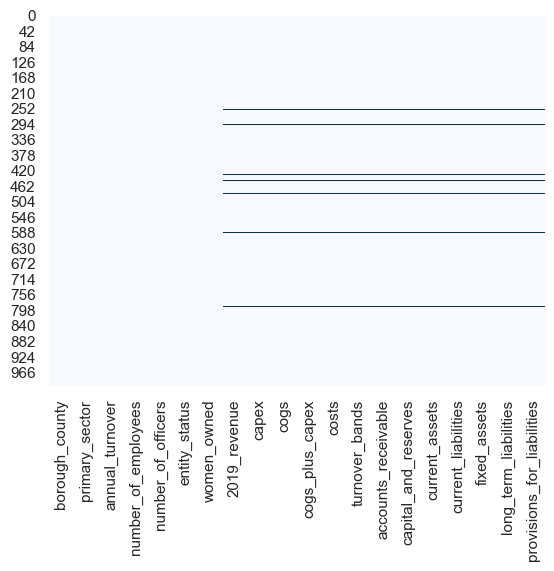

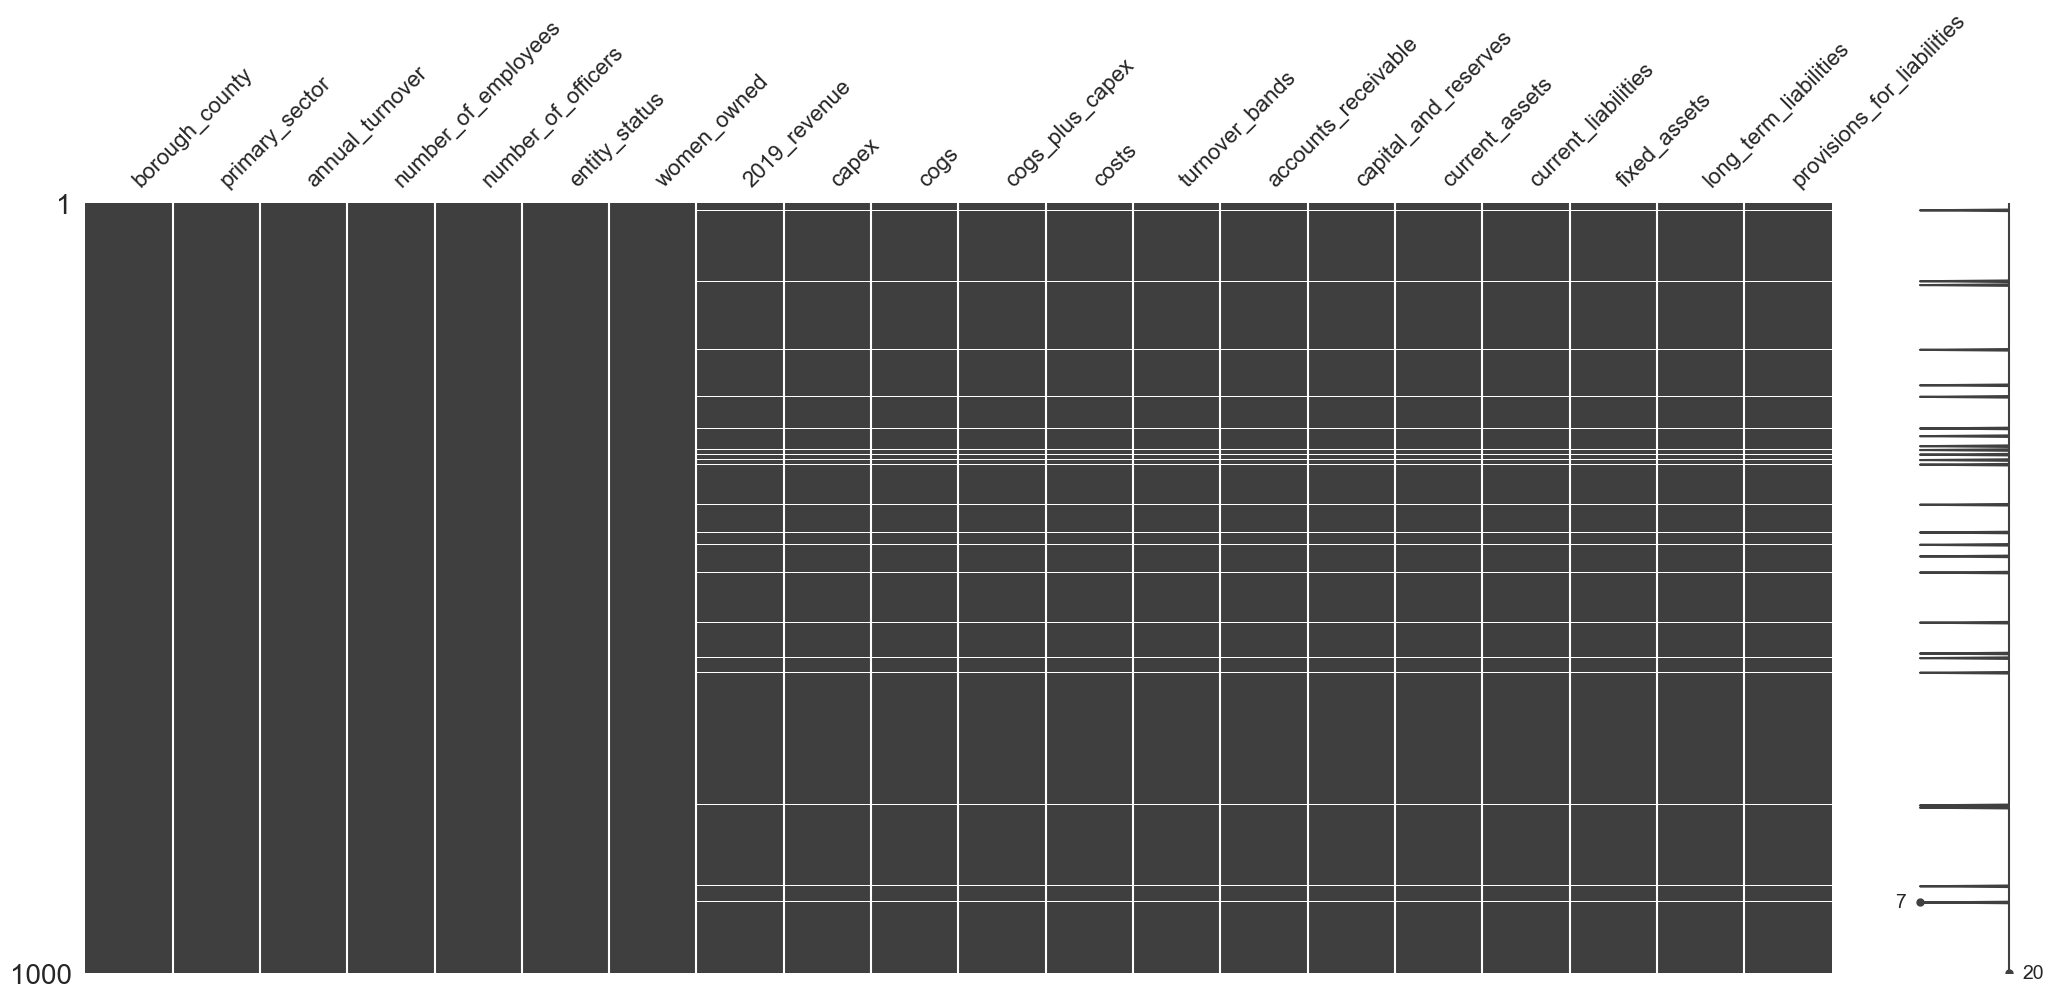

In [368]:
missing = df.isnull()

sns.set_style('darkgrid')
# Create a heatmap
sns.heatmap(missing, cbar=False, cmap='Blues')
plt.ylabel('')

plt.savefig('0.png', bbox_inches="tight")

msno.matrix(df)

plt.show()

# Display the plot
plt.show()

In [369]:
categorical_col = 'turnover_bands'

# Select all columns except the one to exclude
selected_columns = ['2019_revenue','capex','cogs','cogs_plus_capex','costs','accounts_receivable','capital_and_reserves','current_assets','current_liabilities','fixed_assets','long_term_liabilities','provisions_for_liabilities']

mode_category = df['turnover_bands'].mode()[0]

# Replace missing values with the mode category
df['turnover_bands'].fillna(mode_category, inplace=True)

for col in selected_columns :
    mean_val = df[col].mean()
    df[col].fillna(mean_val, inplace=True)

print(df.isna().sum())


borough_county                0
primary_sector                0
annual_turnover               0
number_of_employees           0
number_of_officers            0
entity_status                 0
women_owned                   0
2019_revenue                  0
capex                         0
cogs                          0
cogs_plus_capex               0
costs                         0
turnover_bands                0
accounts_receivable           0
capital_and_reserves          0
current_assets                0
current_liabilities           0
fixed_assets                  0
long_term_liabilities         0
provisions_for_liabilities    0
dtype: int64


## Checking for data-specific statistics

In [370]:
print(df['primary_sector'].unique())

['47 : Retail' '41-43 : Construction' '05-39 : Production'
 '49-53 : Transport & Storage (inc. postal)'
 '69-75 : Professional, scientific & technical'
 '58-63 : Information & communication' '64-66 : Finance & insurance'
 '77-82 : Business administration & support services' '46 : Wholesale'
 '85 : Education' '90-99 : Arts, entertainment, recreation & other'
 '01-03 : Agriculture, forestry & fishing'
 '55-56 : Accommodation & food services' '86-88 : Health' '68 : Property'
 '45 : Motor trades' '84 : Public administration & defence']


we can split primary sector here into two columns one which represents code for the sector and one for its name

In [371]:
print(df['number_of_employees'].unique())

['5-9 People' '0-4 People' '20-49 People' '10-19 People']


we can set this to be between 0 and 3

In [372]:
print(df['annual_turnover'].unique())
print(df['turnover_bands'].unique())

['0-632k' '632k-10.2M']
['0-632k' '1M-10.2M' '632k-1M']


we can set these to be between 0 and 1 and set the other one to be between 0 and 2

we will split the dataset here, one for classification and one for analysis

In [373]:
df_classification = df.copy()

## Feature engineering

We apply some feature engineering to allow the data to be represented in visualizations aswell as prepare it for classification

In [374]:
df[['sector_code', 'sector_description']] = df['primary_sector'].str.split(' : ', n=1, expand=True)

df['sector_code'] = df['sector_code'].str.extract(r'(\d{2})')

df.drop('primary_sector',axis=1)


df_classification[['sector_code', 'sector_description']] = df_classification['primary_sector'].str.split(' : ', n=1, expand=True)

df_classification['sector_code'] = df_classification['sector_code'].str.extract(r'(\d{2})')

In [375]:


emp_categories = {
     '0-4 People':0,
     '5-9 People':1,
     '10-19 People':2,
    '20-49 People':3
}

df_classification['number_of_employees'] = df_classification['number_of_employees'].map(emp_categories)

df_classification['number_of_employees'].head()

0    1
1    0
2    0
3    0
4    0
Name: number_of_employees, dtype: int64

The data is ready for classification analysis

In [376]:
turnover_categories = {
    '0-632k': 0,
    '632k-10.2M':1,
}
band_turnover_categories = {
    '0-632k': 0,
    '1M-10.2M':1,
    '632k-1M':2
}
df_classification['annual_turnover'] = df_classification['annual_turnover'].map(turnover_categories)
df_classification['turnover_bands'] = df_classification['turnover_bands'].map(band_turnover_categories)

df_classification.drop('borough_county',axis=1,inplace=True)

df_classification.drop('primary_sector',axis=1,inplace=True)

df_classification.drop('sector_description',axis=1,inplace=True)

df_classification['sector_code'] = df_classification['sector_code'].apply(pd.to_numeric, errors='coerce')

df_classification['turnover_bands'] = df_classification['turnover_bands'].fillna(df_classification['turnover_bands'].median())

df_classification.drop('sector_code',axis=1,inplace=True)

print(df_classification.isna().sum())

df_classification.dtypes

annual_turnover               0
number_of_employees           0
number_of_officers            0
entity_status                 0
women_owned                   0
2019_revenue                  0
capex                         0
cogs                          0
cogs_plus_capex               0
costs                         0
turnover_bands                0
accounts_receivable           0
capital_and_reserves          0
current_assets                0
current_liabilities           0
fixed_assets                  0
long_term_liabilities         0
provisions_for_liabilities    0
dtype: int64


annual_turnover                 int64
number_of_employees             int64
number_of_officers              int64
entity_status                   int64
women_owned                     int64
2019_revenue                  float64
capex                         float64
cogs                          float64
cogs_plus_capex               float64
costs                         float64
turnover_bands                  int64
accounts_receivable           float64
capital_and_reserves          float64
current_assets                float64
current_liabilities           float64
fixed_assets                  float64
long_term_liabilities         float64
provisions_for_liabilities    float64
dtype: object

## Explanatory Data Analysis

Checking data for abnormal patterns using boxplot

Checking statistics for the dataset for possible candidate sensitive attributes in the dataset that can cause unethical bias decisions

## Stacked bar plot of non-women-owned and women-owned businesses by entity status

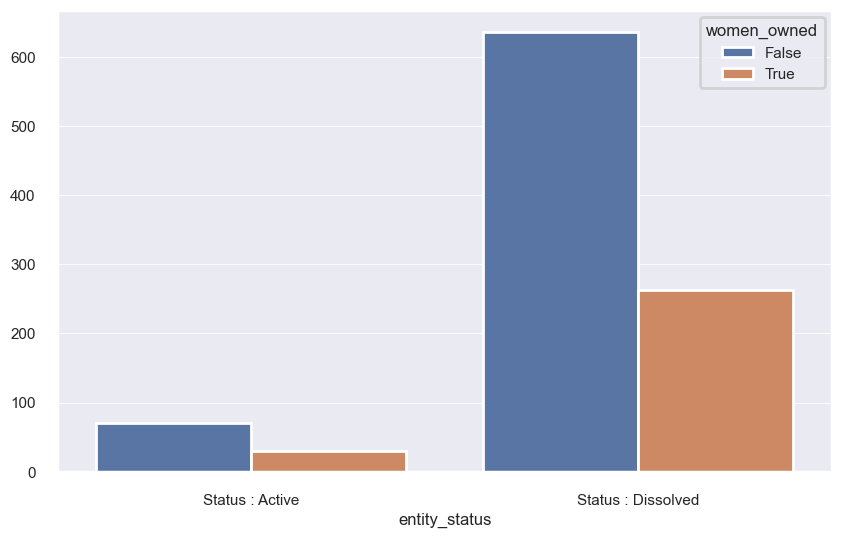

In [377]:
df['entity_status_text'] = df['entity_status'].map({0: 'Status : Active', 1: 'Status : Dissolved'})
df['women_owned_text'] = df['women_owned'].map({1: 'True', 0: 'False'})

# Calculate the counts
count_df = df.groupby(['entity_status_text', 'women_owned_text']).size().reset_index(name='count')

sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.6})
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='entity_status_text', y='count', hue='women_owned_text', data=count_df)

plt.xlabel('entity_status')
plt.ylabel('')
plt.legend(title='women_owned')

plt.savefig('1.png')
plt.show()


## Bar plot of ratio of active enterprises to total enterprises by group

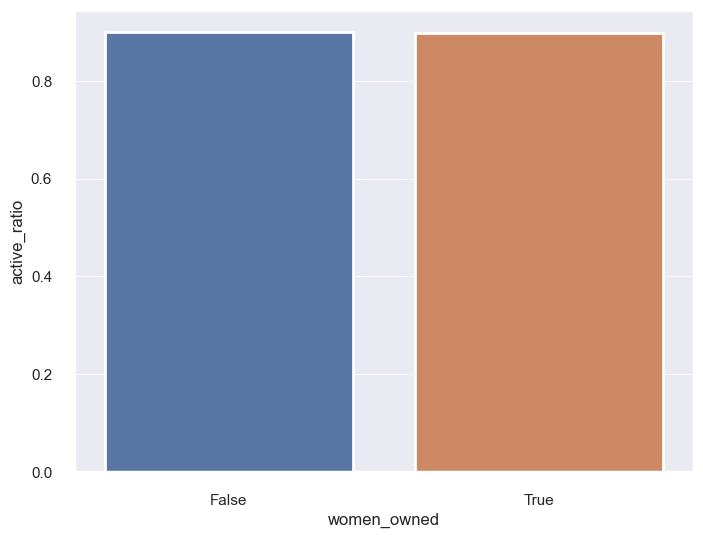

In [378]:
# Calculate the ratios
ratios = df.groupby('women_owned')['entity_status'].agg(['mean']).reset_index()
ratios.columns = ['women_owned', 'active_ratio']
ratios['women_owned'] = ratios['women_owned'].map({1: 'True', 0: 'False'})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='women_owned', y='active_ratio', data=ratios)
plt.ylabel('active_ratio')
plt.xlabel('women_owned')

plt.savefig('2.png')
plt.show()


## Ratio of inactive enterprises to total enterprises for each group

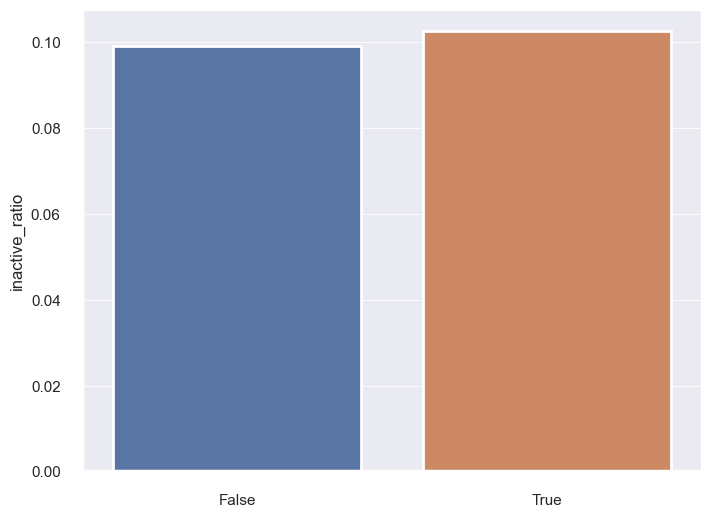

In [379]:
# Calculate the ratio of inactive entities amongst women_owned group
ratio_df = df.groupby('women_owned')['entity_status'].agg(lambda x: (x==0).mean()).reset_index()
ratio_df.columns = ['women_owned', 'inactive_ratio']
ratio_df['women_owned'] = ratio_df['women_owned'].map({1: 'True', 0: 'False'})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='women_owned', y='inactive_ratio', data=ratio_df)
plt.xlabel('')
plt.savefig('3.png')
plt.show()

/var/folders/9j/c40cr7h12sx7qv3bcj5w4p8m0000gn/T/ipykernel_1479/86319279.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Count', y='sector_description', hue='women_owned', data=df_count, estimator=sum, ci=None, orient='h')


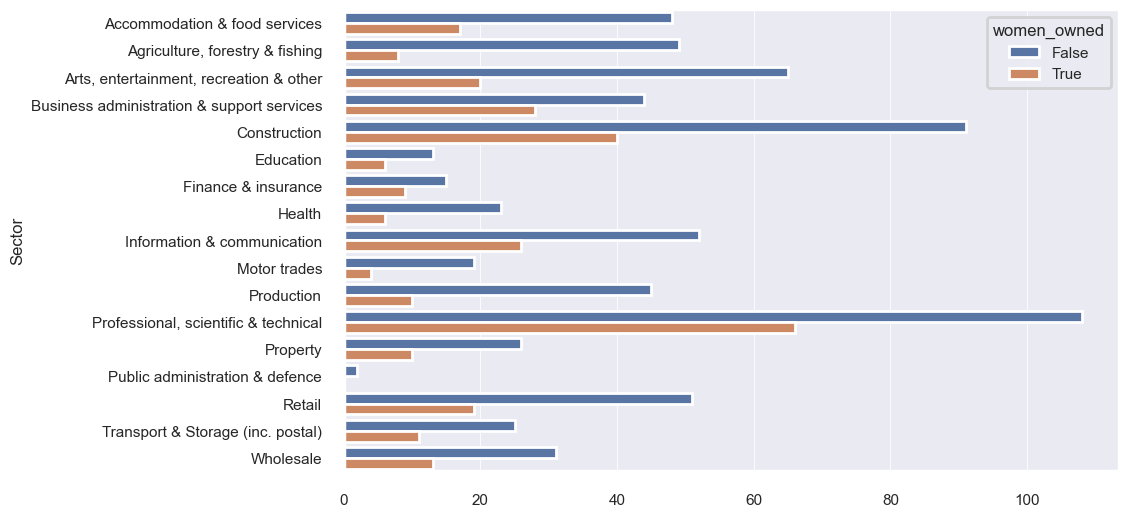

In [380]:

df_count = df.groupby(['sector_description', 'women_owned']).size().reset_index(name='Count')

# Mapping the women-owned category for clarity in the plot
df_count['women_owned'] = df_count['women_owned'].map({1: 'True', 0: 'False'})

# Creating a horizontally stacked bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='sector_description', hue='women_owned', data=df_count, estimator=sum, ci=None, orient='h')

# Customizing the plot
plt.xlabel('')
plt.ylabel('Sector')
plt.savefig('4.png')
# Show the plot
plt.show()


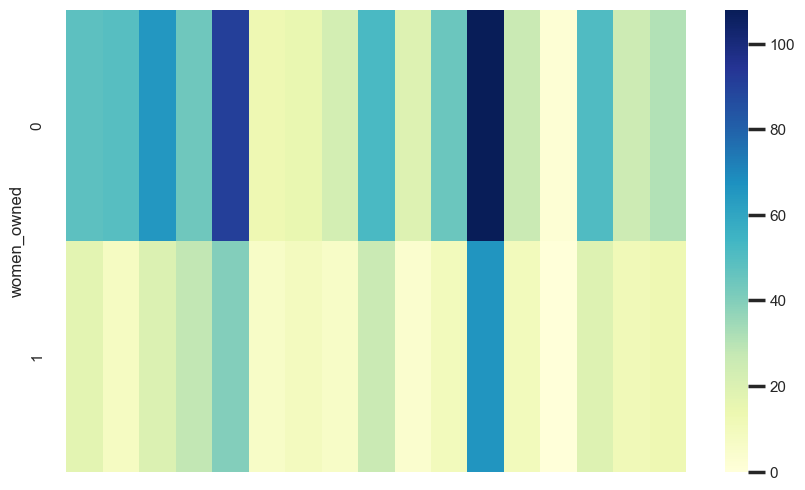

In [381]:
# Count the number of entries in each group (Sector, Women_Owned)
grouped_data = df.groupby(['women_owned', 'sector_description']).size().unstack(fill_value=0)

# Creating the heat map
plt.figure(figsize=(10, 6))
sns.heatmap(grouped_data, annot=False, cmap="YlGnBu")

plt.xticks([])
plt.xlabel('')

# Customizing the plot
plt.ylabel('women_owned')

plt.savefig('5.png')
# Show the plot
plt.show()


## Plot of average revenue per ownership of entity

Interesting to see that women_owned businesses generate more revenue despite having less observations in the data

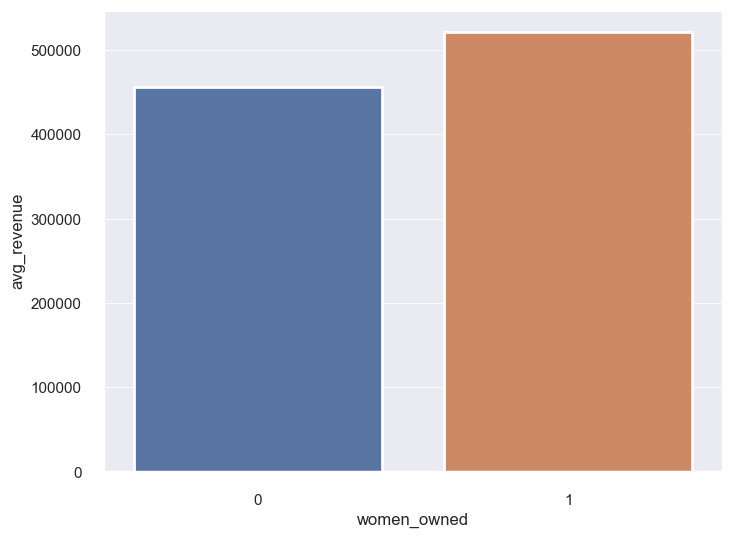

In [382]:
average_revenue = df.groupby('women_owned')['2019_revenue'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='women_owned', y='2019_revenue', data=average_revenue)
plt.xlabel('women_owned')
plt.ylabel('avg_revenue')

plt.savefig('6.png')
plt.show()


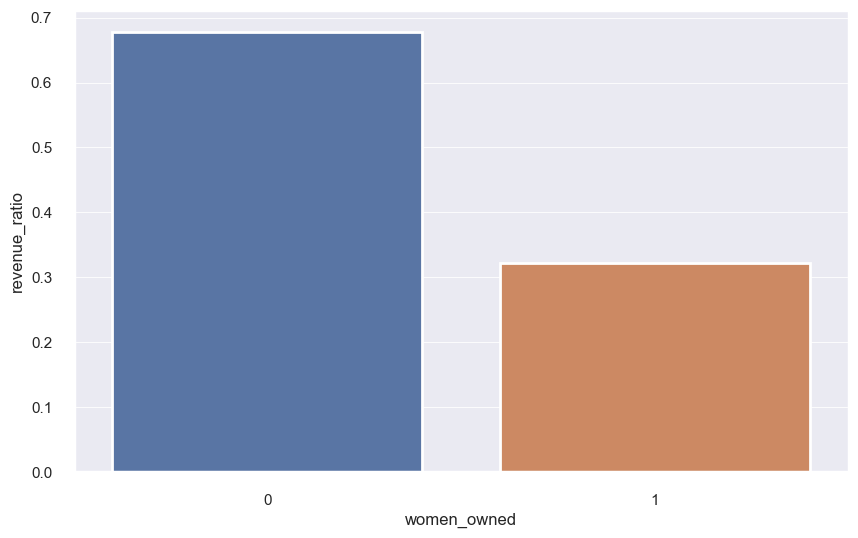

In [383]:
# Calculate total revenue for women-owned and non-women-owned
total_revenue = df.groupby('women_owned')['2019_revenue'].sum()

# Calculate the ratio of each category to the total revenue
total_revenue_sum = total_revenue.sum()
revenue_ratio = total_revenue / total_revenue_sum

# Convert to DataFrame for plotting
revenue_ratio_df = revenue_ratio.reset_index()
revenue_ratio_df.columns = ['women_owned', 'revenue_ratio']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='women_owned', y='revenue_ratio', data=revenue_ratio_df)
plt.xlabel('women_owned')


plt.savefig('7.png')
# Show the plot
plt.show()


## Chloropeth map to visualize distribution of enterprise ownership by gender

0      Cambridgeshire
1          Derbyshire
2               Devon
3               Essex
4     Gloucestershire
5                Kent
6          Lancashire
7          Merseyside
8     Nottinghamshire
9        Outer London
10           Somerset
11            Suffolk
12      Tyne and Wear
13       Warwickshire
Name: CTY22NM, dtype: object
0      Buckinghamshire
1       Cambridgeshire
2              Cumbria
3           Derbyshire
4                Devon
5          East Sussex
6                Essex
7      Gloucestershire
8            Hampshire
9        Hertfordshire
10                Kent
11          Lancashire
12      Leicestershire
13        Lincolnshire
14             Norfolk
15    Northamptonshire
16     North Yorkshire
17     Nottinghamshire
18         Oxfordshire
19            Somerset
20       Staffordshire
21             Suffolk
22              Surrey
23        Warwickshire
24         West Sussex
25      Worcestershire
Name: cty19nm, dtype: object


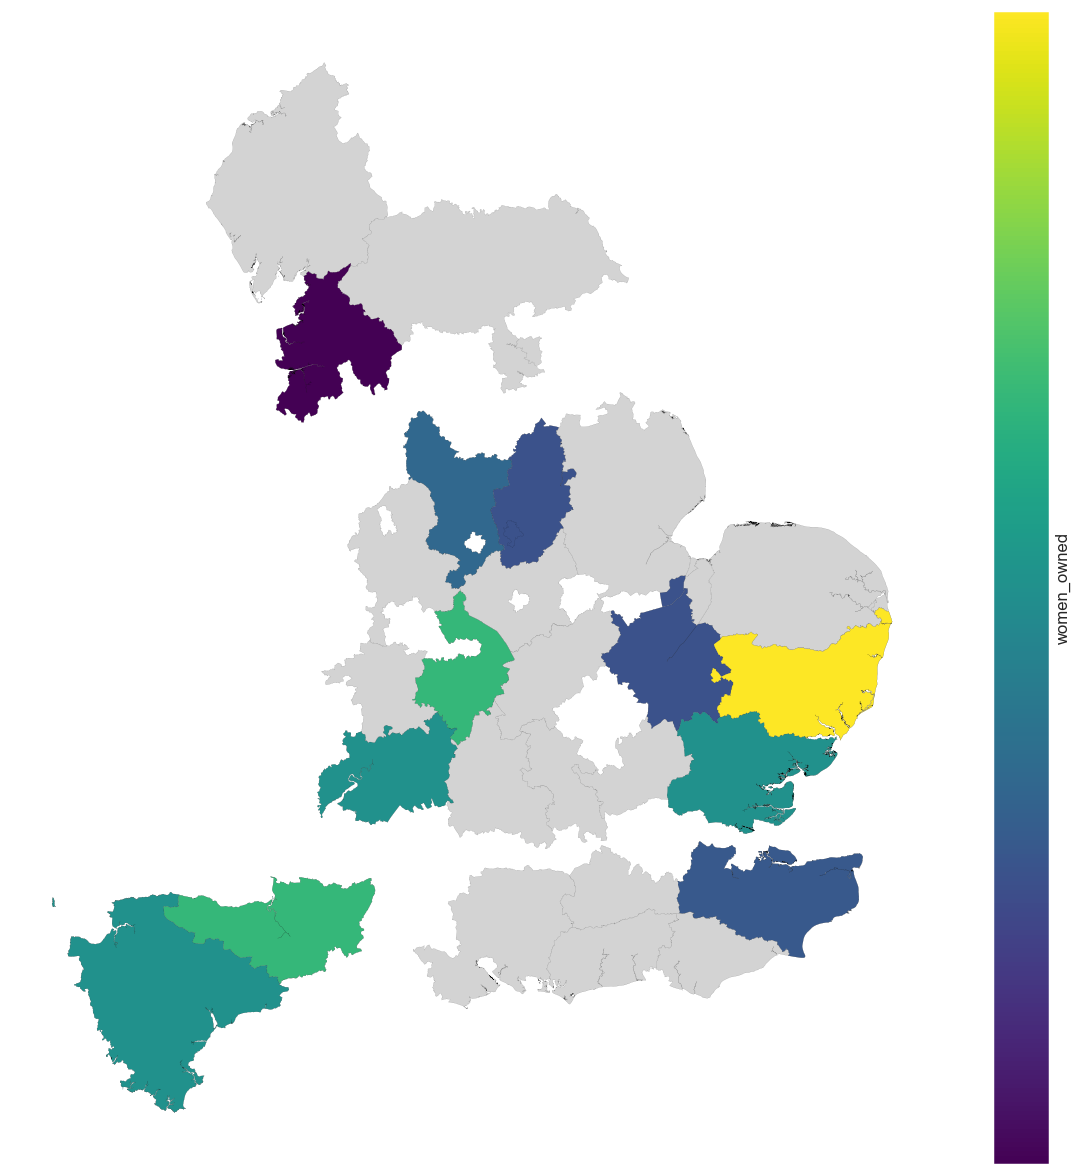

In [384]:
df_borough_to_county = pd.read_csv('./Ward_to_Local_Authority_District_to_County_to_Region_to_Country_(December_2022)_Lookup_in_United_Kingdom.csv')

merged_df = pd.merge(df, df_borough_to_county[['WD22NM', 'CTY22NM']], left_on='borough_county',right_on='WD22NM', how='left')


# Calculate the average ownership for each county
avg_ownership = merged_df.groupby('CTY22NM')['women_owned'].mean().reset_index()

print(avg_ownership['CTY22NM'])
# Load the shapefile for UK counties
uk_counties = gpd.read_file('./Counties_December_2019_FCB_EN_2022_1647862099992050837.geojson')

print(uk_counties['cty19nm'])
# Merge the geospatial data with your business data
map_data = uk_counties.merge(avg_ownership, left_on='cty19nm', right_on='CTY22NM')

# Plotting the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
## make missing counties light grey colored
uk_counties.plot(ax=ax)

ax.set_facecolor('black')

# Remove axis grid and set background color
ax.set_axis_off()

# Plot the base map (all counties) with darker borders
uk_counties.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.05)

map_data.plot(column='women_owned', ax=ax, legend=False,
              legend_kwds={'label': " "},
              cmap='viridis', missing_kwds={'color': 'lightgray'}, edgecolor='black', linewidth=0.05)  # You can choose a different colormap

# custom color bar
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=map_data['women_owned'].min(), vmax=map_data['women_owned'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_ticks([])  # Hides the color bar labels
cbar.set_label('women_owned')
# Add titles and labels as needed
plt.savefig('8.png')
plt.show()


## Chloropeth map detailing entity status by county

0      Cambridgeshire
1          Derbyshire
2               Devon
3               Essex
4     Gloucestershire
5                Kent
6          Lancashire
7          Merseyside
8     Nottinghamshire
9        Outer London
10           Somerset
11            Suffolk
12      Tyne and Wear
13       Warwickshire
Name: CTY22NM, dtype: object
0      Buckinghamshire
1       Cambridgeshire
2              Cumbria
3           Derbyshire
4                Devon
5          East Sussex
6                Essex
7      Gloucestershire
8            Hampshire
9        Hertfordshire
10                Kent
11          Lancashire
12      Leicestershire
13        Lincolnshire
14             Norfolk
15    Northamptonshire
16     North Yorkshire
17     Nottinghamshire
18         Oxfordshire
19            Somerset
20       Staffordshire
21             Suffolk
22              Surrey
23        Warwickshire
24         West Sussex
25      Worcestershire
Name: cty19nm, dtype: object


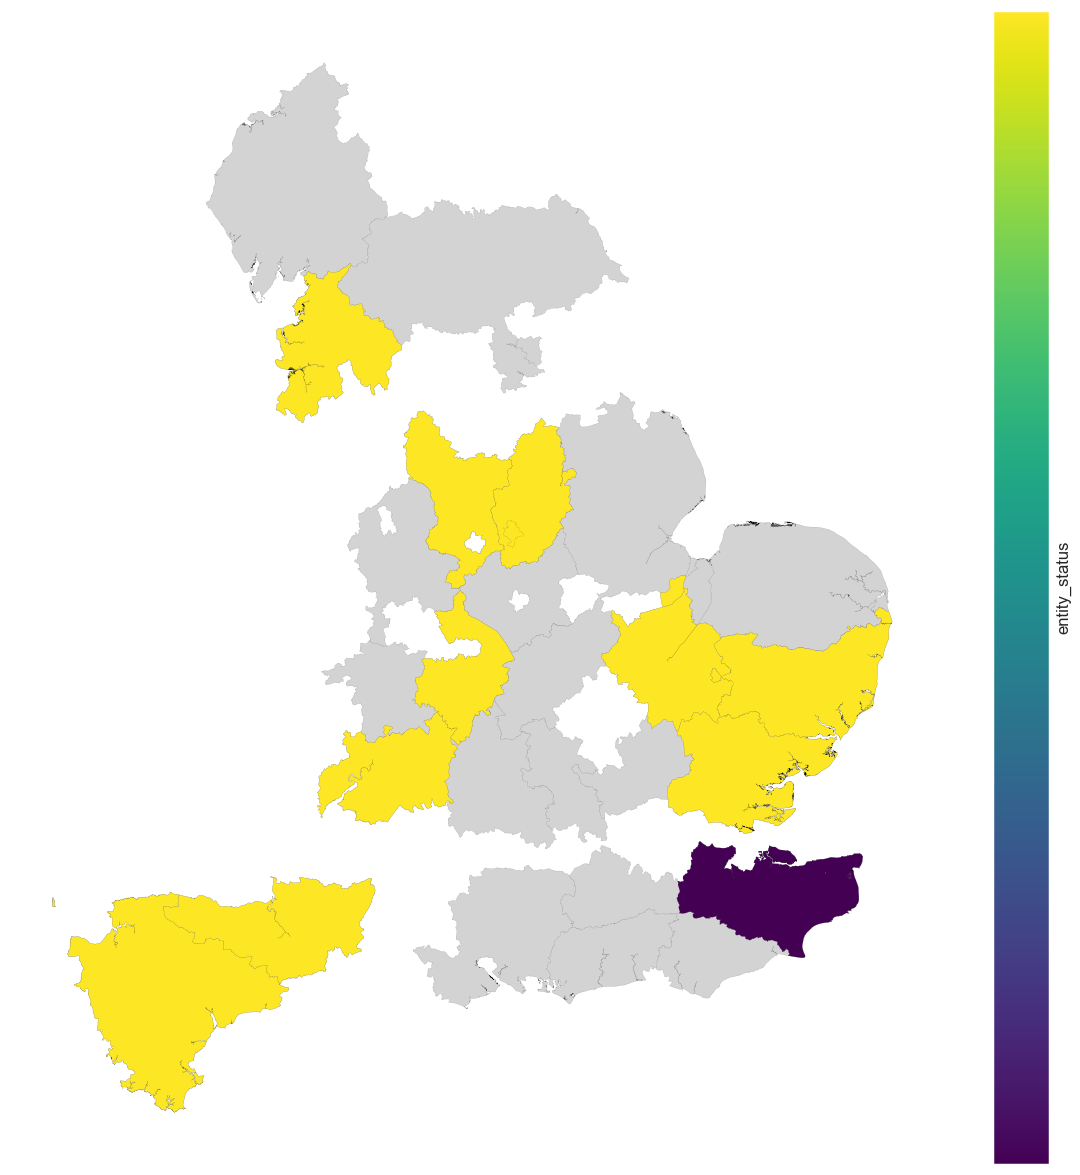

In [385]:
df_borough_to_county = pd.read_csv('./Ward_to_Local_Authority_District_to_County_to_Region_to_Country_(December_2022)_Lookup_in_United_Kingdom.csv')

merged_df = pd.merge(df, df_borough_to_county[['WD22NM', 'CTY22NM']], left_on='borough_county',right_on='WD22NM', how='left')


# Calculate the average ownership for each county
avg_ownership = merged_df.groupby('CTY22NM')['entity_status'].mean().reset_index()

print(avg_ownership['CTY22NM'])
# Load the shapefile for UK counties
uk_counties = gpd.read_file('./Counties_December_2019_FCB_EN_2022_1647862099992050837.geojson')

print(uk_counties['cty19nm'])
# Merge the geospatial data with your business data
map_data = uk_counties.merge(avg_ownership, left_on='cty19nm', right_on='CTY22NM')

# Plotting the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
## make missing counties light grey colored
uk_counties.plot(ax=ax)

ax.set_facecolor('black')

# Remove axis grid and set background color
ax.set_axis_off()

# Plot the base map (all counties) with darker borders
uk_counties.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.05)

map_data.plot(column='entity_status', ax=ax, legend=False,
              legend_kwds={'label': " "},
              cmap='viridis', missing_kwds={'color': 'lightgray'}, edgecolor='black', linewidth=0.05)  # You can choose a different colormap

# custom color bar
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=map_data['entity_status'].min(), vmax=map_data['entity_status'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_ticks([])  # Hides the color bar labels
cbar.set_label('entity_status')
# Add titles and labels as needed
plt.savefig('8.png')
plt.show()


## Correlation plot 

It seems that our dataset is balanced in terms of factors affecting if the entity dissolved or not however we will perform a correlation matrix to see if we can remove some redundant features so our models dont overfit on high feature space

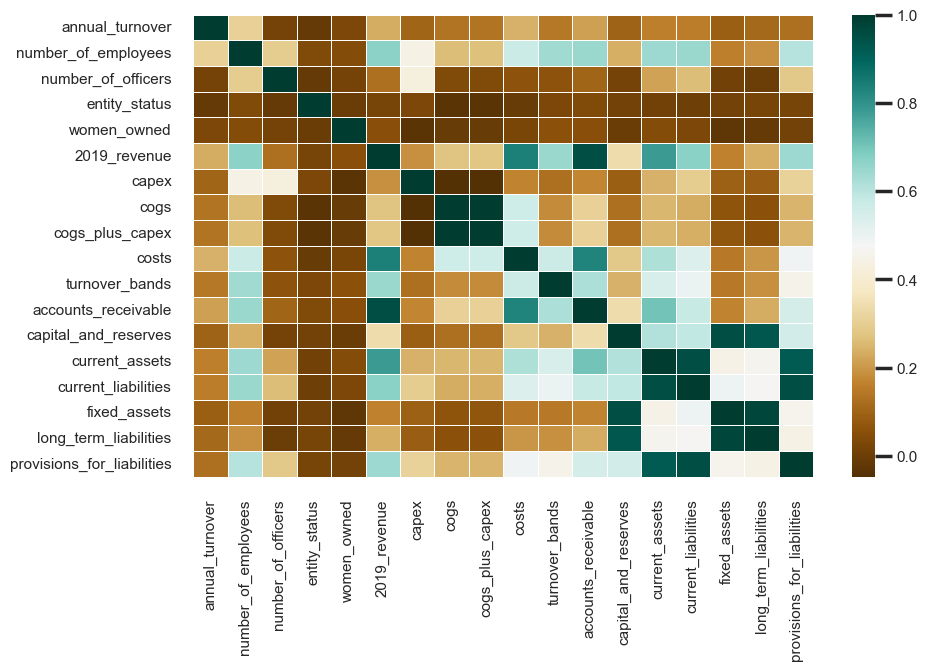

In [386]:
corr = df_classification.corr()
plt.figure(figsize=(10, 6))  # Set the figure size
sns.set_style('darkgrid')
sns.heatmap(corr, annot=False, linewidths=0.5,cmap='BrBG')

plt.savefig('9.png', bbox_inches='tight')
plt.show()

df_classification.drop(['cogs_plus_capex','fixed_assets','provisions_for_liabilities'],axis=1,inplace=True)


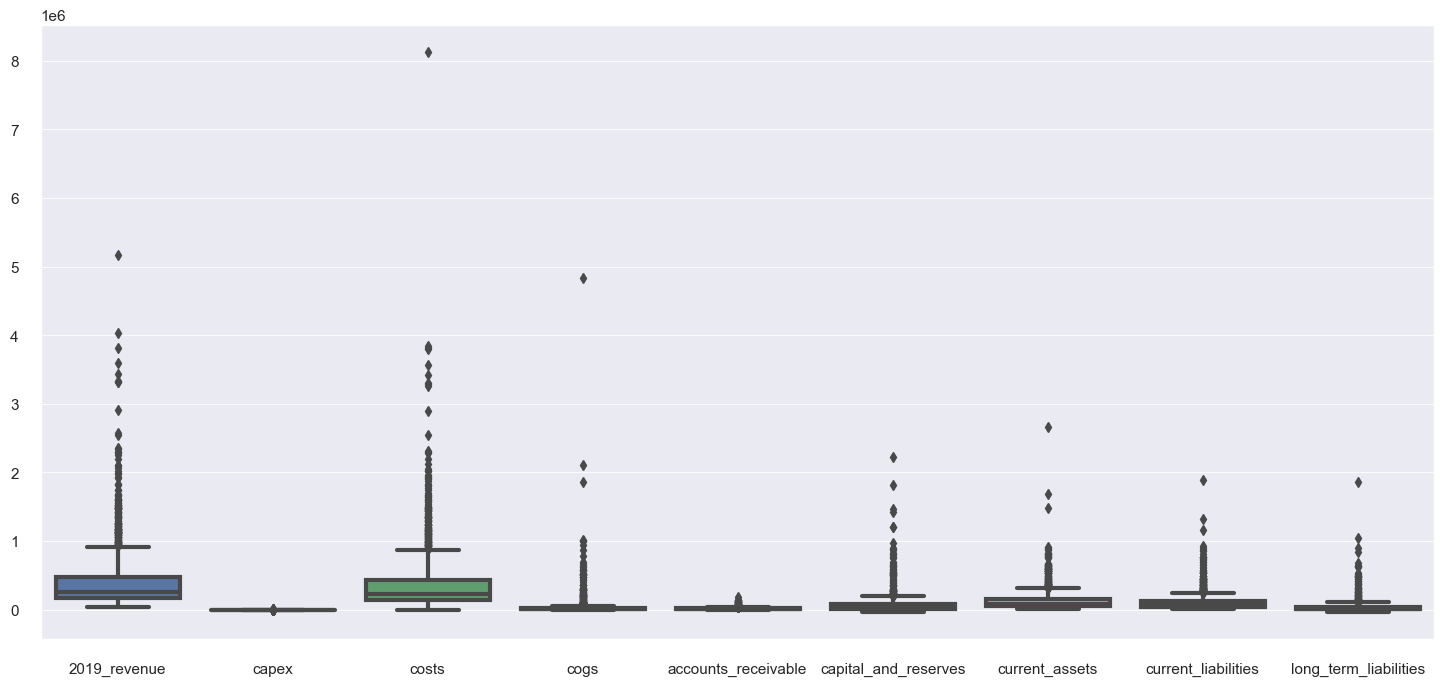

In [387]:
plt.figure(figsize=(18,8))
cols = ['2019_revenue','capex','costs','cogs','accounts_receivable', 'capital_and_reserves','current_assets','current_liabilities','long_term_liabilities']
sns.boxplot(df_classification[cols])

plt.savefig('19.png')
plt.show()

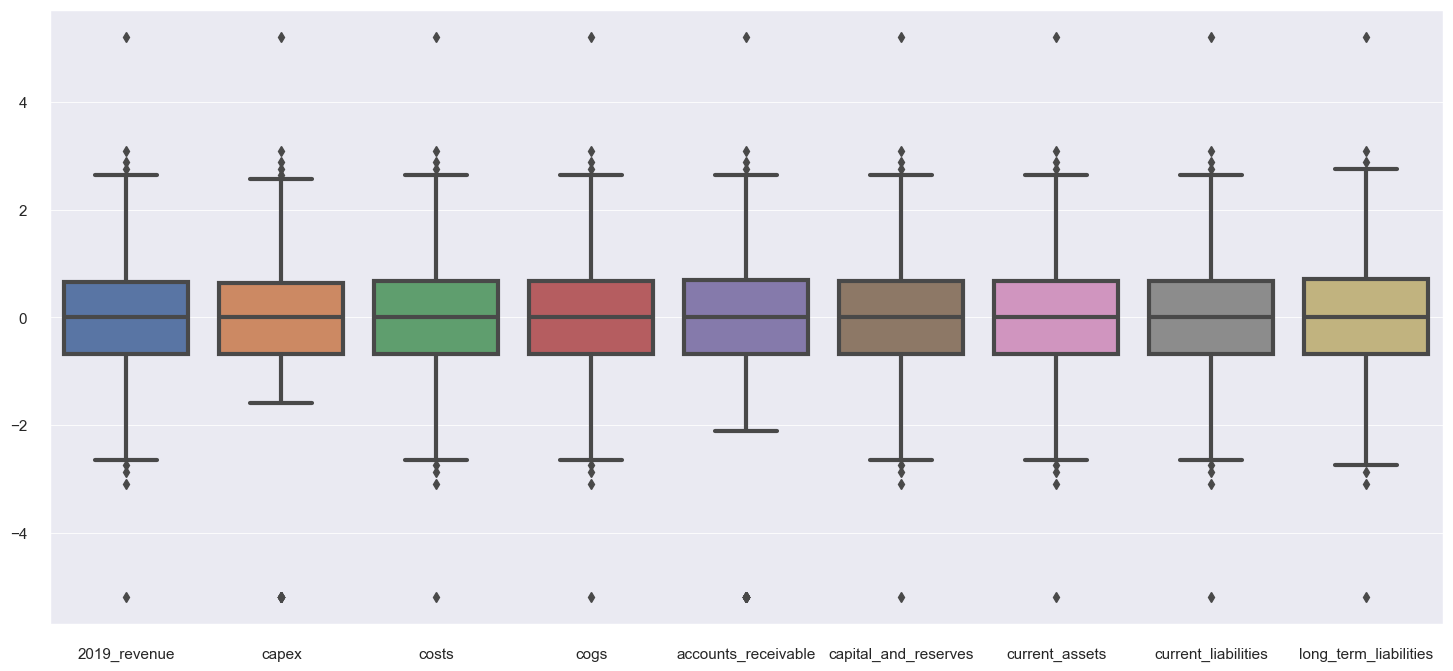

In [388]:
from sklearn.preprocessing import QuantileTransformer


quant_transformer = QuantileTransformer(output_distribution='normal', random_state=0)

df_classification[cols] = quant_transformer.fit_transform(df_classification[cols])


plt.figure(figsize=(18,8))
cols = ['2019_revenue','capex','costs','cogs','accounts_receivable', 'capital_and_reserves','current_assets','current_liabilities','long_term_liabilities']
sns.boxplot(df_classification[cols])

plt.savefig('19.png')
plt.show()

## We split the data and apply SMOTE technique to increase our number of cases 

In [389]:


X = df_classification.drop('entity_status', axis=1)
y = df_classification['entity_status']

smote = SMOTE(sampling_strategy=0.8, random_state=42)  # You can adjust sampling_strategy as needed
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

## classification with random forest to predict the status of the entity business

Using different sampling techniques and different n_estimators for random forest achieved good results since our dataset is particularly small

In [390]:
'''from sklearn.model_selection import KFold


rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_validation)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_validation, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (RF)')
plt.show()

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(y_validation, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (RF)')
plt.legend(loc='lower right')
plt.show()


# Classification report
print(classification_report(y_validation,y_pred))'''



'from sklearn.model_selection import KFold\n\n\nrf_clf = RandomForestClassifier(n_estimators=100, random_state=42)\n\nrf_clf.fit(X_train, y_train)\n\ny_pred = rf_clf.predict(X_validation)\n\n# Create a confusion matrix\nconf_matrix = confusion_matrix(y_validation, y_pred)\n\n# Create a heatmap of the confusion matrix\nplt.figure(figsize=(8, 6))\nsns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Blues\', cbar=False)\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\nplt.title(\'Confusion Matrix (RF)\')\nplt.show()\n\n# Calculate ROC curve and ROC-AUC score\nfpr, tpr, _ = roc_curve(y_validation, y_pred)\nroc_auc = auc(fpr, tpr)\n\n# Plot the ROC curve using Seaborn\nplt.figure(figsize=(8, 6))\nsns.set_style("whitegrid")\nsns.lineplot(x=fpr, y=tpr, color=\'darkorange\', lw=2, label=f\'ROC curve (area = {roc_auc:.2f})\')\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate (FPR)\')\nplt.ylabel

## Support Vector Machines to predict entity of business


I've opted to use smaller c = 0.5 to reduce potential of overfitting and due to limited amount of training data

In [391]:
## I've commented this part because SVM takes a long time

'''svm_clf = SVC(kernel='linear', C=0.5, random_state=42)

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_validation)


# Create a confusion matrix
conf_matrix = confusion_matrix(y_validation, y_pred)

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(y_validation, y_pred)
roc_auc = auc(fpr, tpr)


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()


# Plot the ROC curve using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVM)')
plt.legend(loc='lower right')
plt.show()

# Classification report
print(classification_report(y_validation,y_pred)) '''



'svm_clf = SVC(kernel=\'linear\', C=0.5, random_state=42)\n\nsvm_clf.fit(X_train, y_train)\n\ny_pred = svm_clf.predict(X_validation)\n\n\n# Create a confusion matrix\nconf_matrix = confusion_matrix(y_validation, y_pred)\n\n# Calculate ROC curve and ROC-AUC score\nfpr, tpr, _ = roc_curve(y_validation, y_pred)\nroc_auc = auc(fpr, tpr)\n\n\n# Create a heatmap of the confusion matrix\nplt.figure(figsize=(8, 6))\nsns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Blues\', cbar=False)\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\nplt.title(\'Confusion Matrix (SVM)\')\nplt.show()\n\n\n# Plot the ROC curve using Seaborn\nplt.figure(figsize=(8, 6))\nsns.set_style("darkgrid")\nsns.lineplot(x=fpr, y=tpr, color=\'darkorange\', lw=2, label=f\'ROC curve (area = {roc_auc:.2f})\')\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate (FPR)\')\nplt.ylabel(\'True Positive Rate (TPR)\')\nplt.title(\'Recei

## Logistic Regression

In [392]:
'''lr = LogisticRegression(random_state=42)

# Train the model on the training data
lr.fit(X_train, y_train)

y_pred = lr.predict(X_validation)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_validation, y_pred)

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(y_validation, y_pred)
roc_auc = auc(fpr, tpr)


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LR)')
plt.show()


# Plot the ROC curve using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (LR)')
plt.legend(loc='lower right')
plt.show()

# Classification report
print(classification_report(y_validation,y_pred))'''


'lr = LogisticRegression(random_state=42)\n\n# Train the model on the training data\nlr.fit(X_train, y_train)\n\ny_pred = lr.predict(X_validation)\n\n# Create a confusion matrix\nconf_matrix = confusion_matrix(y_validation, y_pred)\n\n# Calculate ROC curve and ROC-AUC score\nfpr, tpr, _ = roc_curve(y_validation, y_pred)\nroc_auc = auc(fpr, tpr)\n\n\n# Create a heatmap of the confusion matrix\nplt.figure(figsize=(8, 6))\nsns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Blues\', cbar=False)\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\nplt.title(\'Confusion Matrix (LR)\')\nplt.show()\n\n\n# Plot the ROC curve using Seaborn\nplt.figure(figsize=(8, 6))\nsns.set_style("darkgrid")\nsns.lineplot(x=fpr, y=tpr, color=\'darkorange\', lw=2, label=f\'ROC curve (area = {roc_auc:.2f})\')\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate (FPR)\')\nplt.ylabel(\'True Positive Rate (TPR)\')\nplt.ti

## Finally the last one : K-Nearest Neighbor

In [393]:
'''knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_validation)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_validation, y_pred)

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(y_validation, y_pred)
roc_auc = auc(fpr, tpr)


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LR)')
plt.show()


# Plot the ROC curve using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("dark")
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (LR)')
plt.legend(loc='lower right')
plt.show()

# Classification report
print(classification_report(y_validation,y_pred))'''

'knn = KNeighborsClassifier(n_neighbors=5)\n\nknn.fit(X_train, y_train)\n\ny_pred = knn.predict(X_validation)\n\n# Create a confusion matrix\nconf_matrix = confusion_matrix(y_validation, y_pred)\n\n# Calculate ROC curve and ROC-AUC score\nfpr, tpr, _ = roc_curve(y_validation, y_pred)\nroc_auc = auc(fpr, tpr)\n\n\n# Create a heatmap of the confusion matrix\nplt.figure(figsize=(8, 6))\nsns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Blues\', cbar=False)\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\nplt.title(\'Confusion Matrix (LR)\')\nplt.show()\n\n\n# Plot the ROC curve using Seaborn\nplt.figure(figsize=(8, 6))\nsns.set_style("dark")\nsns.lineplot(x=fpr, y=tpr, color=\'darkorange\', lw=2, label=f\'ROC curve (area = {roc_auc:.2f})\')\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate (FPR)\')\nplt.ylabel(\'True Positive Rate (TPR)\')\nplt.title(\'Receiver Operating Characteristic (

## Training and cross validation

Cross-validation is very useful for small datasets, it reduces chances of overfitting

Model: Logistic Regression


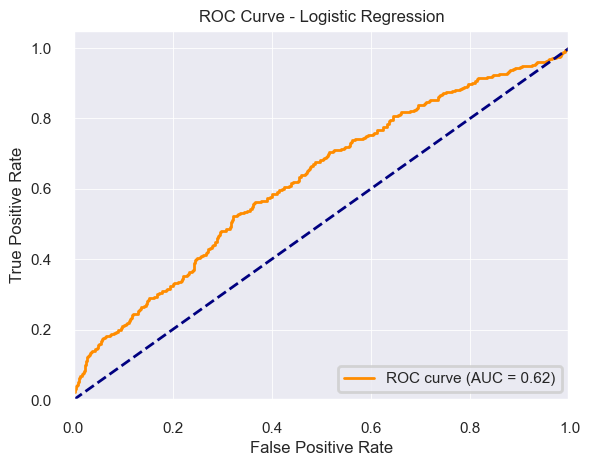

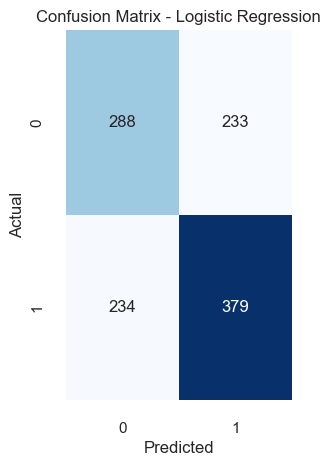

Classification Report - Logistic Regression:
               precision    recall  f1-score   support

           0       0.55      0.55      0.55       521
           1       0.62      0.62      0.62       613

    accuracy                           0.59      1134
   macro avg       0.59      0.59      0.59      1134
weighted avg       0.59      0.59      0.59      1134







/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Model: Random Forest


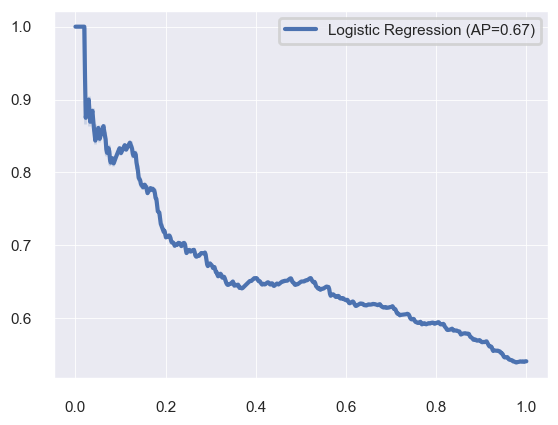

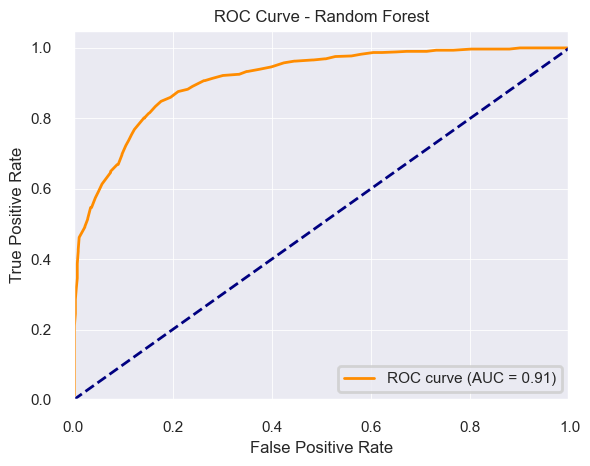

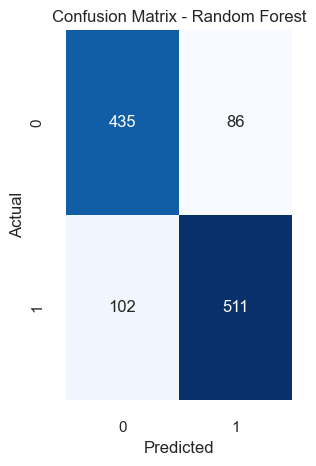

Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       521
           1       0.86      0.83      0.84       613

    accuracy                           0.83      1134
   macro avg       0.83      0.83      0.83      1134
weighted avg       0.83      0.83      0.83      1134





Model: Support Vector Machine


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


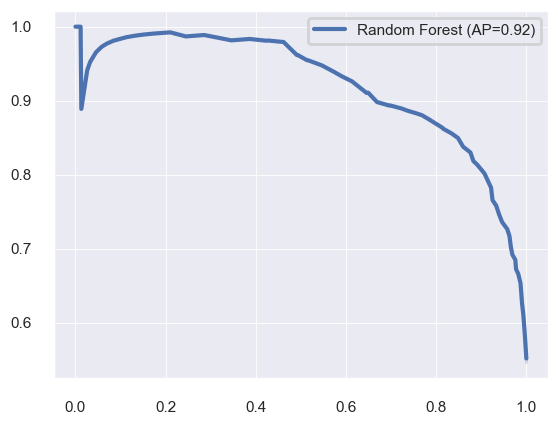

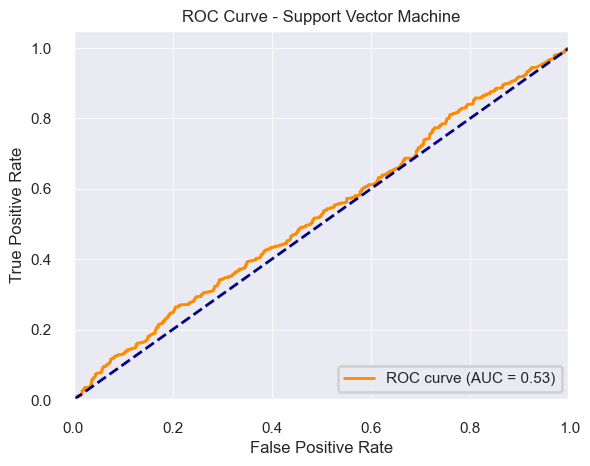

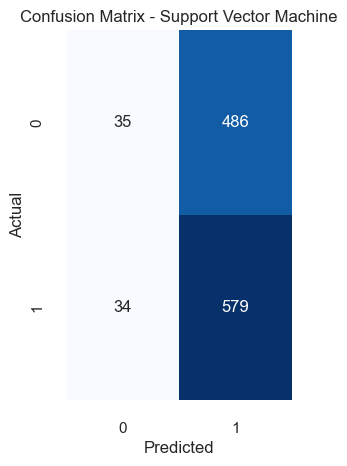

Classification Report - Support Vector Machine:
               precision    recall  f1-score   support

           0       0.51      0.07      0.12       521
           1       0.54      0.94      0.69       613

    accuracy                           0.54      1134
   macro avg       0.53      0.51      0.40      1134
weighted avg       0.53      0.54      0.43      1134







/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Model: K-Nearest Neighbors


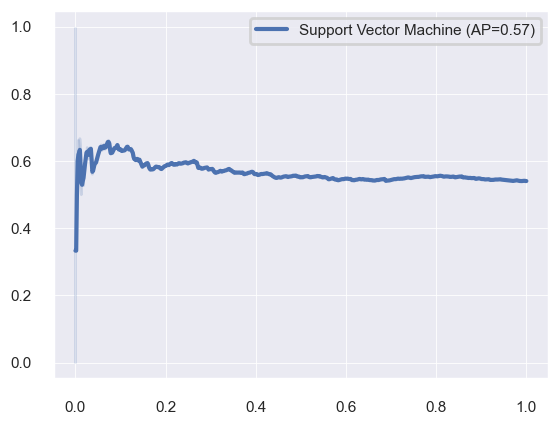

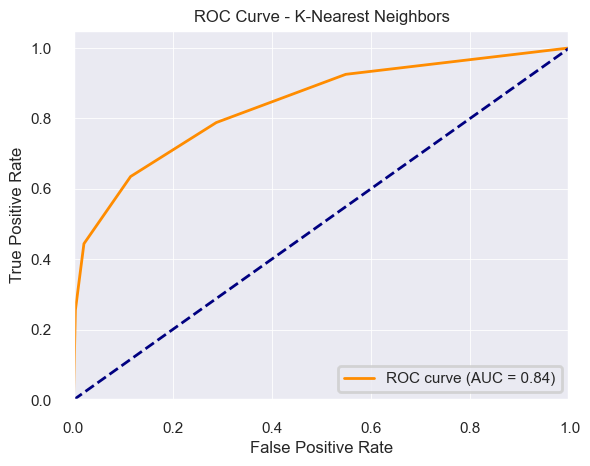

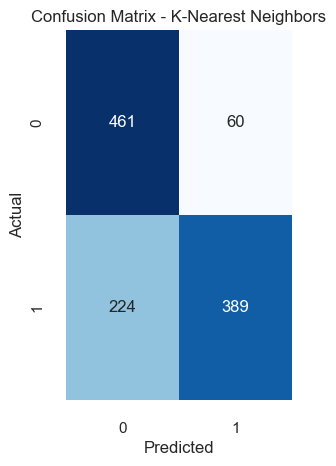

Classification Report - K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.67      0.88      0.76       521
           1       0.87      0.63      0.73       613

    accuracy                           0.75      1134
   macro avg       0.77      0.76      0.75      1134
weighted avg       0.78      0.75      0.75      1134







/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


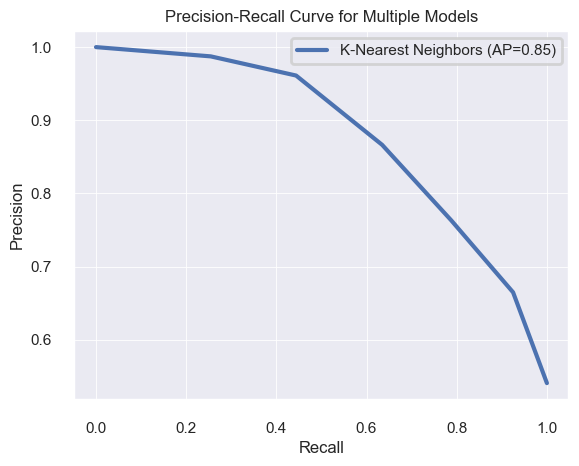

RandomForestClassifier(n_estimators=75)


In [394]:
from sklearn.calibration import cross_val_predict
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import KFold


models = [
    ('Logistic Regression', LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)),
    ('Random Forest', RandomForestClassifier(n_estimators=75)),
    ('Support Vector Machine', SVC(probability=True, C=0.5, kernel='sigmoid')),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5,metric='euclidean'))  
]

best_model = None
best_score = 0
ct = 11
num_folds = 5
ct2 = 0

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for model_name, model in models:
    print(f"Model: {model_name}")
    
    # Perform cross-validation and get predicted probabilities
    pred_prob = cross_val_predict(model, X_train, y_train, cv=kf, method='predict_proba')
    
    # Calculate ROC curve and AUC-ROC
    fpr, tpr, _ = roc_curve(y_train, pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'{ct}.png')
    plt.show()
    
    print("\n" + "="*50 + "\n")  # Separator

     # Confusion Matrix
    plt.subplot(1, 2, 2)
    predicted_labels = np.argmax(pred_prob, axis=1)
    cm = confusion_matrix(y_train, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'{ct+1}.png')
    plt.show()

    predicted_labels = np.argmax(pred_prob, axis=1)
    report = classification_report(y_train, predicted_labels)
    print(f"Classification Report - {model_name}:\n", report)

    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_model = model
    
    print("\n" + "="*50 + "\n")  
    
    print("\n" + "="*50 + "\n")  # Separator

    precision, recall, _ = precision_recall_curve(y_train, pred_prob[:, 1])
    average_precision = average_precision_score(y_train, pred_prob[:, 1])

    # Plot the Precision-Recall curve for the model
    sns.lineplot(x=recall, y=precision, label=f'{model_name} (AP={average_precision:0.2f})')

# Labels and Legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiple Models')
plt.legend()

# Show the plot
plt.show()
ct += 2
ct2+= 1

print(best_model)

## Now we use Random Forest to test the model one final time and apply fairness metrics on our groups

Metric tests used:

Disparate Impact shows significant bias signs having a value of less than 1 meaning there is bias against unprivileged group (women-owned)
Statistical Parity Difference shows some bias signs have a value of -0.3 meaning the ratio of outcomes of unprvileged groups to privileged groups is uneven
Average Odds Difference
Equal Odds Difference shows little bias
I chose those metrics because they prove more accuracy the best in binary classification


We present a null hypothesis H0 which claims that there is no significant bias in the outcome of the model
In case we do find significant bias we reject H0



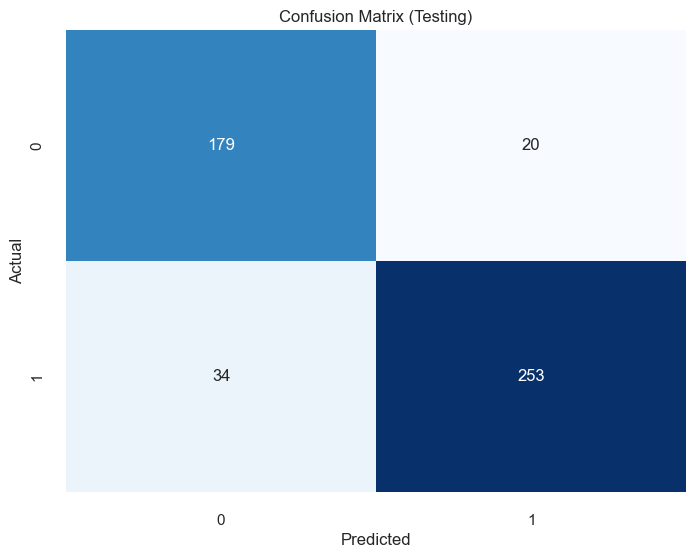

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


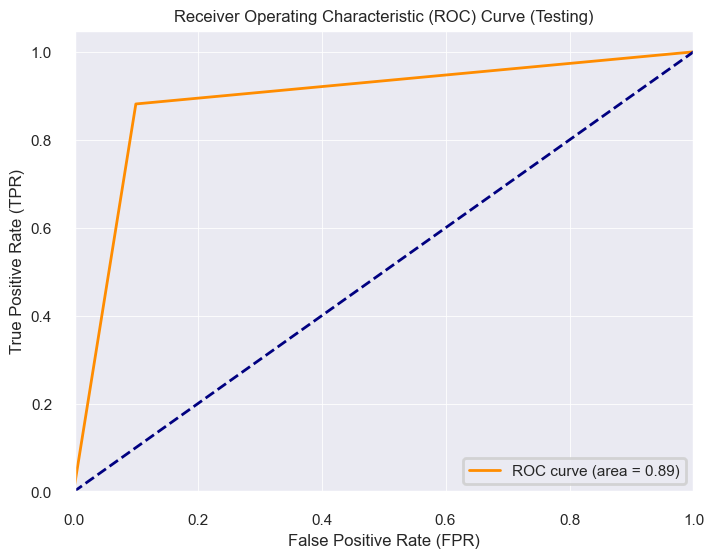

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       199
           1       0.93      0.88      0.90       287

    accuracy                           0.89       486
   macro avg       0.88      0.89      0.89       486
weighted avg       0.89      0.89      0.89       486

0.6177147239263804
-0.1740572625698324
Disparate Impact:  0.5127604166666666
Statistical Parity Difference:  -0.2449807960893855
Equal Opportunity Difference: -0.0468643490115882
Average Odds Difference: -0.09461389133968484
Consistency: 0.7329218106995878


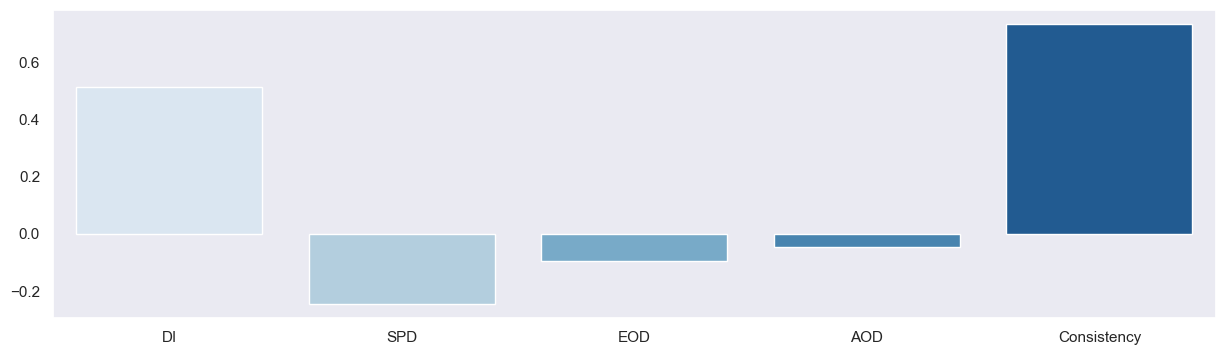

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


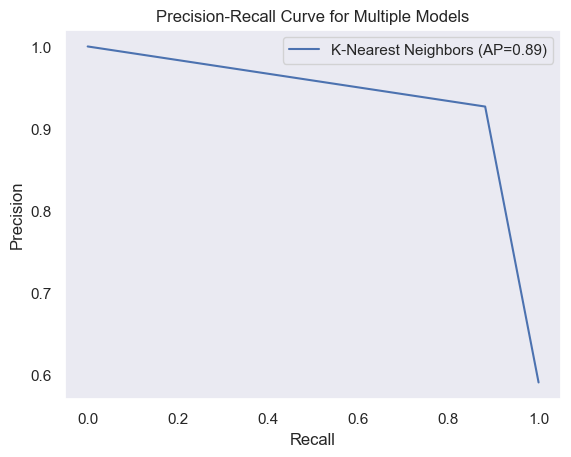

In [395]:
# Define the label and protected attribute
label_name = 'entity_status' 
protected_attribute_name = ['women_owned']

privileged_groups = [{'women_owned': 0}]
unprivileged_groups = [{'women_owned': 1}]


best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)


# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing)')
plt.show()


# Plot the ROC curve using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (Testing)')
plt.legend(loc='lower right')
plt.show()

# Classification report
print(classification_report(y_test,y_pred))
# Retrieve AIF360 parameters for each step we compare the original dataset to the predicted one

bin_dataset_test = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                  label_names=[label_name], protected_attribute_names=protected_attribute_name,favorable_label=0,unfavorable_label=1)


# Create a BinaryLabelDataset for the predictions
bin_dataset_pred = bin_dataset_test.copy()
bin_dataset_pred.labels = y_pred



metric_test_3 = BinaryLabelDatasetMetric(bin_dataset_test, unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)

print(metric_test_3.disparate_impact())
print(metric_test_3.statistical_parity_difference())
# Compute fairness metrics on AIF360 parameters
metric_test = BinaryLabelDatasetMetric(bin_dataset_pred, 
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

metric_test_2 = ClassificationMetric(bin_dataset_test,bin_dataset_pred,unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

EOD_val = metric_test_2.equal_opportunity_difference()

AOD_val = metric_test_2.average_odds_difference()

disp_imp_val = metric_test.disparate_impact()

stat_parity_val = metric_test.statistical_parity_difference()

const_val = metric_test.consistency()

print("Disparate Impact: ", disp_imp_val)
print("Statistical Parity Difference: ", stat_parity_val)
print("Equal Opportunity Difference:", EOD_val )
print("Average Odds Difference:", AOD_val)
print("Consistency:", const_val)

metrics  = {
    'Metric': ['DI', 'SPD', 'EOD' , 'AOD', 'Consistency'],
    'Value': [disp_imp_val,stat_parity_val,AOD_val, EOD_val,const_val]
}
metrics_df = pd.DataFrame(metrics)
# Set a Seaborn style (optional)
sns.set(style="dark")

# Create a bar plot for the fairness metrics
plt.figure(figsize=(15, 4))
sns.barplot(data=metrics_df, x='Metric', y='Value', palette='Blues')
plt.xlabel('')
plt.ylabel('')

plt.savefig('18.png')
# Show the plot
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve for the model
sns.lineplot(x=recall, y=precision, label=f'{model_name} (AP={average_precision:0.2f})')

# Labels and Legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiple Models')
plt.legend()

plt.show()



## Debiasing using preprocessing

For debiasing we applied a preprocessing technique (Reweighing) to the data seeing as the fault lies within the data itself.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


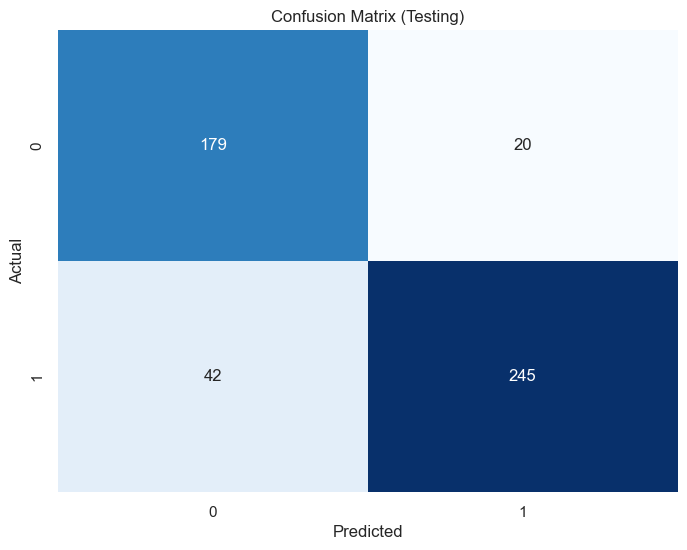

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


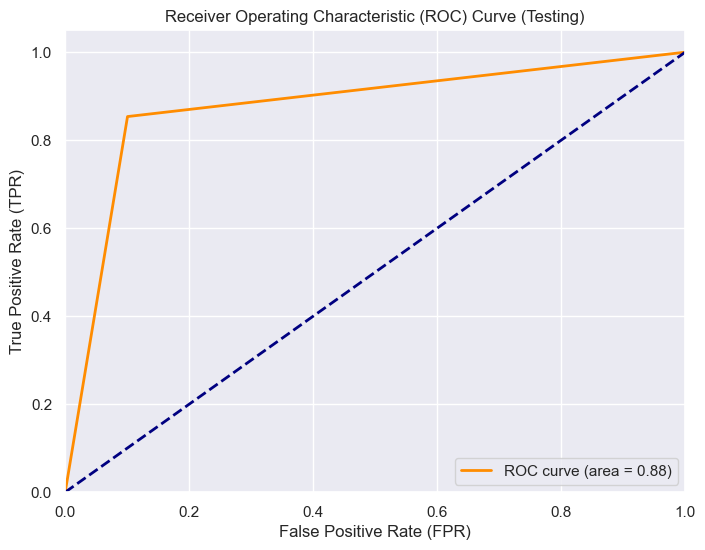

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       199
           1       0.92      0.85      0.89       287

    accuracy                           0.87       486
   macro avg       0.87      0.88      0.87       486
weighted avg       0.88      0.87      0.87       486

DI:  0.526293682795699
SPD:  -0.24611557262569828
EOD: -0.11468984321745057
AOD: -0.11704391826424368
Consistency: 0.7530864197530858


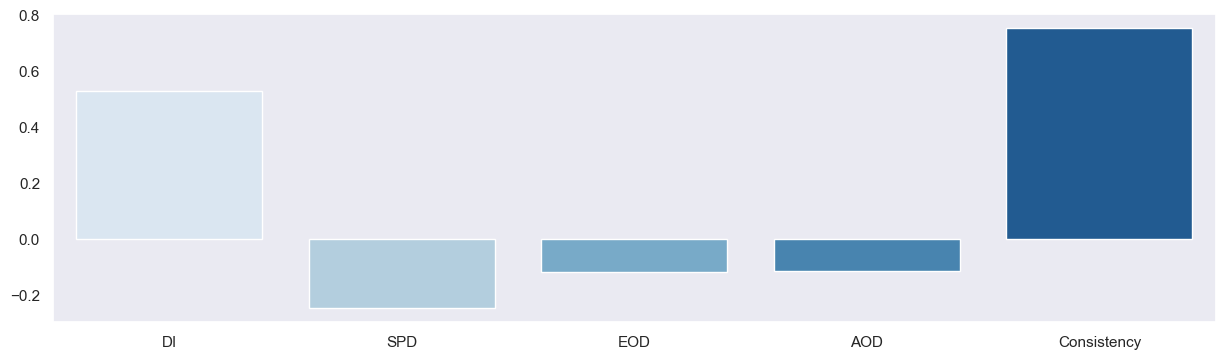

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


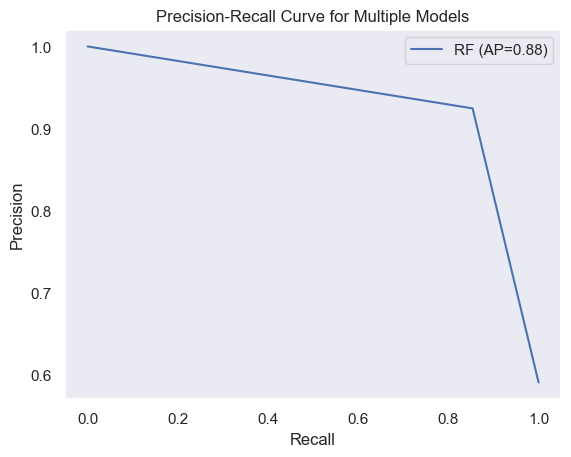

In [396]:
bin_dataset_train = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),label_names=[label_name], protected_attribute_names=protected_attribute_name,favorable_label=0, unfavorable_label=1)
# Initialize Reweighing and fit to the dataset
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
rw.fit(bin_dataset_train)


transformed_dataset = rw.transform(bin_dataset_train)


X_train_rw, y_train_rw = transformed_dataset.features, transformed_dataset.labels.ravel()


best_model.fit(X_train_rw,y_train_rw)

y_pred = best_model.predict(X_test)



# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing)')
plt.show()


# Plot the ROC curve using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (Testing)')
plt.legend(loc='lower right')
plt.show()

# Classification report
print(classification_report(y_test,y_pred))


# Create a BinaryLabelDataset for the predictions
predicted_test_dataset_rw = bin_dataset_test.copy()
predicted_test_dataset_rw.labels = y_pred


rw_metric_test = BinaryLabelDatasetMetric(predicted_test_dataset_rw, 
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

rw_class_metric_test = ClassificationMetric(bin_dataset_test,predicted_test_dataset_rw,unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

EOD_val = rw_class_metric_test.equal_opportunity_difference()

AOD_val = rw_class_metric_test.average_odds_difference()

disp_imp_val = rw_metric_test.disparate_impact()

stat_parity_val = rw_metric_test.statistical_parity_difference()

const_val = rw_metric_test.consistency()

print("DI: ", disp_imp_val)
print("SPD: ", stat_parity_val)
print("EOD:", EOD_val )
print("AOD:", AOD_val)
print("Consistency:", const_val)

metrics  = {
    'Metric': ['DI', 'SPD', 'EOD' , 'AOD', 'Consistency'],
    'Value': [disp_imp_val,stat_parity_val,AOD_val, EOD_val,const_val]
}
metrics_df = pd.DataFrame(metrics)
# Set a Seaborn style (optional)
sns.set(style="dark")

# Create a bar plot for the fairness metrics
plt.figure(figsize=(15, 4))
sns.barplot(data=metrics_df, x='Metric', y='Value', palette='Blues')
plt.xlabel('')
plt.ylabel('')
plt.savefig('21.png')

# Show the plot
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve for the model
sns.lineplot(x=recall, y=precision, label=f'RF (AP={average_precision:0.2f})')

# Labels and Legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiple Models')
plt.legend()

plt.show()

## debiasing using preprocessing (Disparate Impact Remover)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


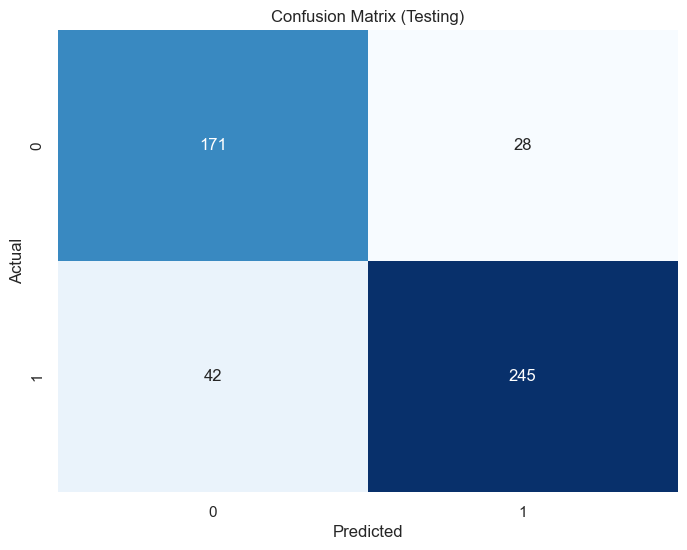

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


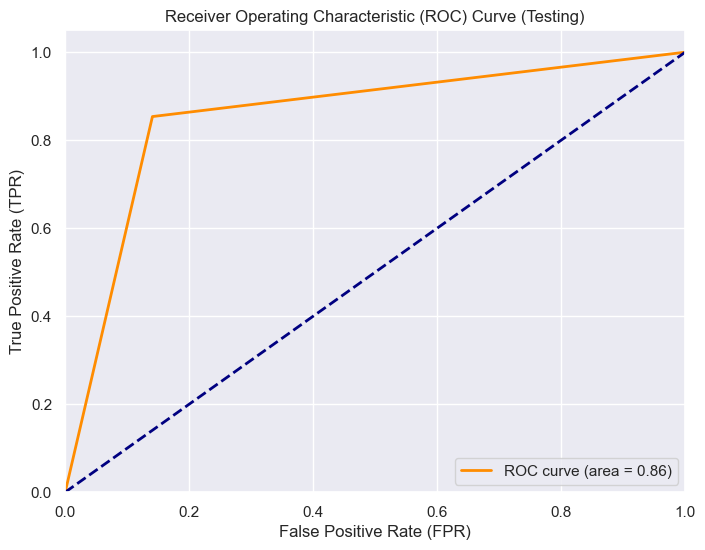

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       199
           1       0.90      0.85      0.88       287

    accuracy                           0.86       486
   macro avg       0.85      0.86      0.85       486
weighted avg       0.86      0.86      0.86       486

Disparate Impact:  0.5127604166666666
Statistical Parity Difference:  -0.2449807960893855
Equal Opportunity Difference: -0.06561008861622353
Average Odds Difference: -0.10850181130922659
Consistency Value:  0.7469135802469128


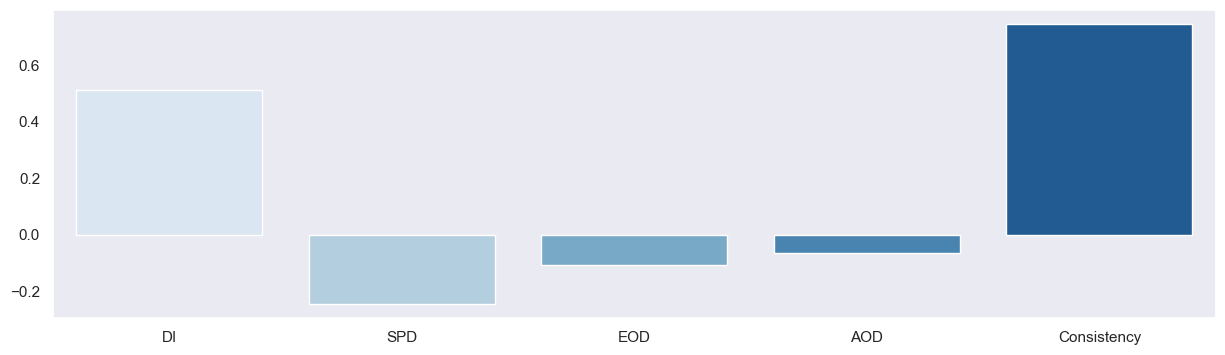

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


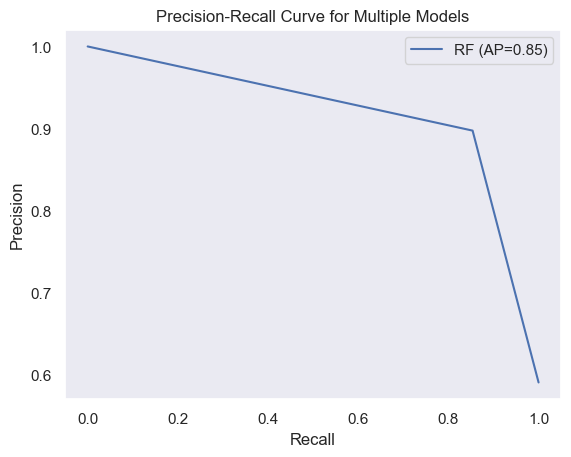

In [397]:
di_remover = DisparateImpactRemover(repair_level=1.0)
repaired_dataset = di_remover.fit_transform(bin_dataset_train)

X_train_dir, y_train_dir = repaired_dataset.features, transformed_dataset.labels.ravel()


best_model.fit(X_train_dir,y_train_dir)

y_pred = best_model.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate ROC curve and ROC-AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing)')
plt.show()


# Plot the ROC curve using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.lineplot(x=fpr, y=tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (Testing)')
plt.legend(loc='lower right')
plt.show()

# Classification report
print(classification_report(y_test,y_pred))


# Create a BinaryLabelDataset for the predictions
predicted_test_dataset_dir = bin_dataset_test.copy()
predicted_test_dataset_dir.labels = y_pred


dir_metric_test = BinaryLabelDatasetMetric(predicted_test_dataset_dir, 
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

dir_class_metric_test = ClassificationMetric(bin_dataset_test,predicted_test_dataset_dir,unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)

EOD_val = dir_class_metric_test.equal_opportunity_difference()

AOD_val = dir_class_metric_test.average_odds_difference()

disp_imp_val = dir_metric_test.disparate_impact()

stat_parity_val = dir_metric_test.statistical_parity_difference()

const_val = dir_metric_test.consistency()

print("Disparate Impact: ", disp_imp_val)
print("Statistical Parity Difference: ", stat_parity_val)
print("Equal Opportunity Difference:", EOD_val )
print("Average Odds Difference:", AOD_val)
print("Consistency Value: ", const_val)

metrics  = {
    'Metric': ['DI', 'SPD', 'EOD' , 'AOD','Consistency'],
    'Value': [disp_imp_val,stat_parity_val,AOD_val, EOD_val,const_val]
}
metrics_df = pd.DataFrame(metrics)
# Set a Seaborn style (optional)
sns.set(style="dark")

# Create a bar plot for the fairness metrics
plt.figure(figsize=(15, 4))
sns.barplot(data=metrics_df, x='Metric', y='Value', palette='Blues')
plt.xlabel('')
plt.ylabel('')
plt.savefig('21.png')

# Show the plot
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve for the model
sns.lineplot(x=recall, y=precision, label=f'RF (AP={average_precision:0.2f})')

# Labels and Legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiple Models')
plt.legend()

plt.show()


##  Applying calibrated equality of odds


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.88      0.84       199
           1       0.91      0.86      0.88       287

    accuracy                           0.87       486
   macro avg       0.86      0.87      0.86       486
weighted avg       0.87      0.87      0.87       486

Disparate Impact:  0.6177147239263804
Statistical Parity Difference:  -0.1740572625698324
Equal Opportunity Difference: 0.0
Average Odds Difference: 0.0
Consistency Value:  0.7086419753086415


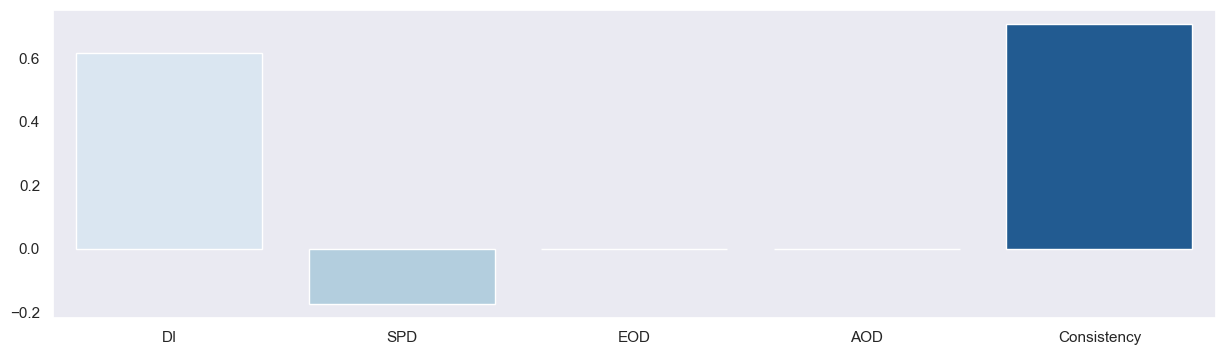

In [398]:

best_model.fit(X_train_dir, y_train_dir)
preds = best_model.predict(X_test)
pred_data = bin_dataset_test.copy()
pred_data.labels = preds

postproc = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups, 
                                unprivileged_groups=unprivileged_groups, cost_constraint='weighted',seed=42)
postproc_ceopp = postproc.fit(bin_dataset_test, pred_data)

postproc_data = postproc_ceopp.predict(pred_data)

metric_ceopp = BinaryLabelDatasetMetric(postproc_data, 
                                  unprivileged_groups=unprivileged_groups, 
                                  privileged_groups=privileged_groups)
class_metric_ceopp = ClassificationMetric(postproc_data, bin_dataset_test, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

print(classification_report(y_test,preds))

EOD_val = class_metric_ceopp.equal_opportunity_difference()

AOD_val = class_metric_ceopp.average_odds_difference()

disp_imp_val = metric_ceopp.disparate_impact()

stat_parity_val = class_metric_ceopp.statistical_parity_difference()

const_val = metric_ceopp.consistency()[0]

print("Disparate Impact: ", disp_imp_val)
print("Statistical Parity Difference: ", stat_parity_val)
print("Equal Opportunity Difference:", EOD_val )
print("Average Odds Difference:", AOD_val)
print("Consistency Value: ", const_val)

metrics  = {
    'Metric': ['DI', 'SPD', 'EOD' , 'AOD','Consistency'],
    'Value': [disp_imp_val,stat_parity_val,AOD_val, EOD_val,const_val]
}
metrics_df = pd.DataFrame(metrics)
# Set a Seaborn style (optional)
sns.set(style="dark")

# Create a bar plot for the fairness metrics
plt.figure(figsize=(15, 4))
sns.barplot(data=metrics_df, x='Metric', y='Value', palette='Blues')
plt.xlabel('')
plt.ylabel('')
plt.savefig('23.png')

# Show the plot
plt.show()

